<a href="https://colab.research.google.com/github/jialinyi94/MIT-intro-to-flow-and-diffusion-model-labs/blob/main/Lab_One_Simulating_ODEs_and_SDEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab One: Simulating ODEs and SDEs

Welcome to lab one! In this lab, we will provide an intuitive and hands-on walk-through of ODEs and SDEs. If you find any mistakes, or have any other feedback, please feel free to email us at `erives@mit.edu` and `phold@mit.edu`. Enjoy!

In [1]:
from abc import ABC, abstractmethod
from typing import Optional
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Part 0: Introduction

First, let us make precise the central objects of study: *ordinary differential equations* (ODEs) and *stochastic differential equations* (SDEs). The basis of both ODEs and SDEs are time-dependent *vector fields*, which we recall from lecture as being functions $u$ defined by $$u:\mathbb{R}^d\times [0,1]\to \mathbb{R}^d,\quad (x,t)\mapsto u_t(x)$$
That is, $u_t(x)$ takes in *where in space we are* ($x$) and *where in time we are* ($t$), and spits out the *direction we should be going in* $u_t(x)$. An ODE is then given by $$d X_t = u_t(X_t)dt, \quad \quad X_0 = x_0.$$
Similarly, an SDE is of the form $$d X_t = u_t(X_t)dt + \sigma_t d W_t, \quad \quad X_0 = x_0,$$
which can be thought of as starting with an ODE given by $u_t$, and adding noise via the *Brownian motion* $(W_t)_{0 \le t \le 1}$. The amount of noise that we add is given by the *diffusion coefficient* $\sigma_t$.

In [2]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
        Returns:
            - diffusion_coefficient: shape (batch_size, dim)
        """
        pass

**Note**: One might consider an ODE to be a special case of SDEs with zero diffusion coefficient. This intuition is valid, however for pedagogical (and performance) reasons, we will treat them separately for the scope of this lab.

# Part 1: Numerical Methods for Simulating ODEs and SDEs
We may think of ODEs and SDEs as describing the motion of a particle through space. Intuitively, the ODE above says "start at $X_0=x_0$", and move so that your instantaneous velocity is given by $u_t(X_t)$. Similarly, the SDE says "start at $X_0=x_0$", and move so that your instantaneous velocity is given by $u_t(X_t)$ plus a little bit of random noise given scaled by $\sigma_t$. Formally, these trajectories traced out by this intuitive descriptions are said to be *solutions* to the ODEs and SDEs, respectively. Numerical methods for computing these solutions are all essentially based on *simulating*, or *integrating*, the ODE or SDE.

In this section we'll implement the *Euler* and *Euler-Maruyama* numerical simulation schemes for integrating ODEs and SDEs, respectively. Recall from lecture that the Euler simulation scheme corresponds to the discretization
$$d X_t = u_t(X_t) dt  \quad \quad \rightarrow \quad \quad X_{t + h} = X_t + hu_t(X_t),$$
where $h = \Delta t$ is the *step size*. Similarly, the Euler-Maruyama scheme corresponds to the discretization
$$ dX_t = u(X_t,t) dt + \sigma_t d W_t  \quad \quad \rightarrow \quad \quad X_{t + h} = X_t + hu_t(X_t) + \sqrt{h} \sigma_t z_t, \quad z_t \sim N(0,I_d).$$
Let's implement these!

In [3]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

### Question 1.1: Implement EulerSimulator and EulerMaruyamaSimulator

**Your job**: Fill in the `step` methods of `EulerSimulator` and `EulerMaruyamaSimulator`.

In [4]:
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + h * self.ode.drift_coefficient(xt, t)

In [5]:
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + h * self.sde.drift_coefficient(xt, t) + torch.sqrt(h) * self.sde.diffusion_coefficient(xt, t) * torch.randn_like(xt)

**Note:** When the diffusion coefficient is zero, the Euler and Euler-Maruyama simulation are equivalent!

# Part 2: Visualizing Solutions to SDEs
Let's get a feel for what the solutions to these SDEs look like in practice (we'll get to ODEs later...). To do so, we we'll implement and visualize two special choices of SDEs from lecture: a (scaled) *Brownian motion*, and an *Ornstein-Uhlenbeck* (OU) process.

### Question 2.1: Implementing Brownian Motion
First, recall that a Brownian motion is recovered (by definition) by setting $u_t = 0$ and $\sigma_t = \sigma$, viz.,
$$ dX_t = \sigma dW_t, \quad \quad X_0 = 0.$$

**Your job**: Intuitively, what might be expect the trajectories of $X_t$ to look like when $\sigma$ is very large? What about when $\sigma$ is close to zero?

**Your answer**:

**Your job**: Fill in the `drift_coefficient` and `difusion_coefficient` methods of the `BrownianMotion` class below.

In [6]:
class BrownianMotion(SDE):
    def __init__(self, sigma: float):
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return torch.zeros_like(xt)

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return self.sigma * torch.ones_like(xt)

Now let's plot! We'll make use of the following utility function.

In [7]:
def plot_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, ax: Optional[Axes] = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
            ax.plot(ts.cpu(), trajectory.cpu())

100%|██████████| 499/499 [00:00<00:00, 1874.38it/s]


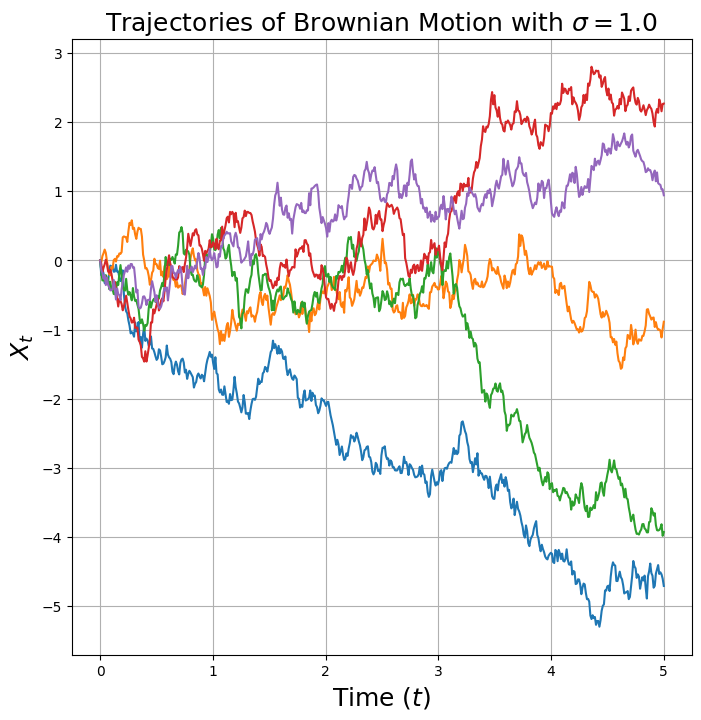

In [8]:
sigma = 1.0
brownian_motion = BrownianMotion(sigma)
simulator = EulerMaruyamaSimulator(sde=brownian_motion)
x0 = torch.zeros(5,1).to(device) # Initial values - let's start at zero
ts = torch.linspace(0.0,5.0,500).to(device) # simulation timesteps

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(sigma), fontsize=18)
ax.set_xlabel(r'Time ($t$)', fontsize=18)
ax.set_ylabel(r'$X_t$', fontsize=18)
ax.grid(True)
plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

**Your job**: What happens when you vary the value of `sigma`?

**Your answer**: when `sigma` is larger, the variance of the final state is larger.

### Question 2.2: Implementing an Ornstein-Uhlenbeck Process
An OU process is given by setting $u_t(X_t) = - \theta X_t$ and $\sigma_t = \sigma$, viz.,
$$ dX_t = -\theta X_t\, dt + \sigma\, dW_t, \quad \quad X_0 = x_0.$$

**Your job**: Intuitively, what would the trajectory of $X_t$ look like for a very small value of $\theta$? What about a very large value of $\theta$?

**Your answer**: the larger $\theta$ is, the faster $X_t$ converges

**Your job**: Fill in the `drift_coefficient` and `difusion_coefficient` methods of the `OUProcess` class below.

In [9]:
class OUProcess(SDE):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return self.theta * xt

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return self.sigma * torch.ones_like(xt)

100%|██████████| 999/999 [00:00<00:00, 6003.21it/s]


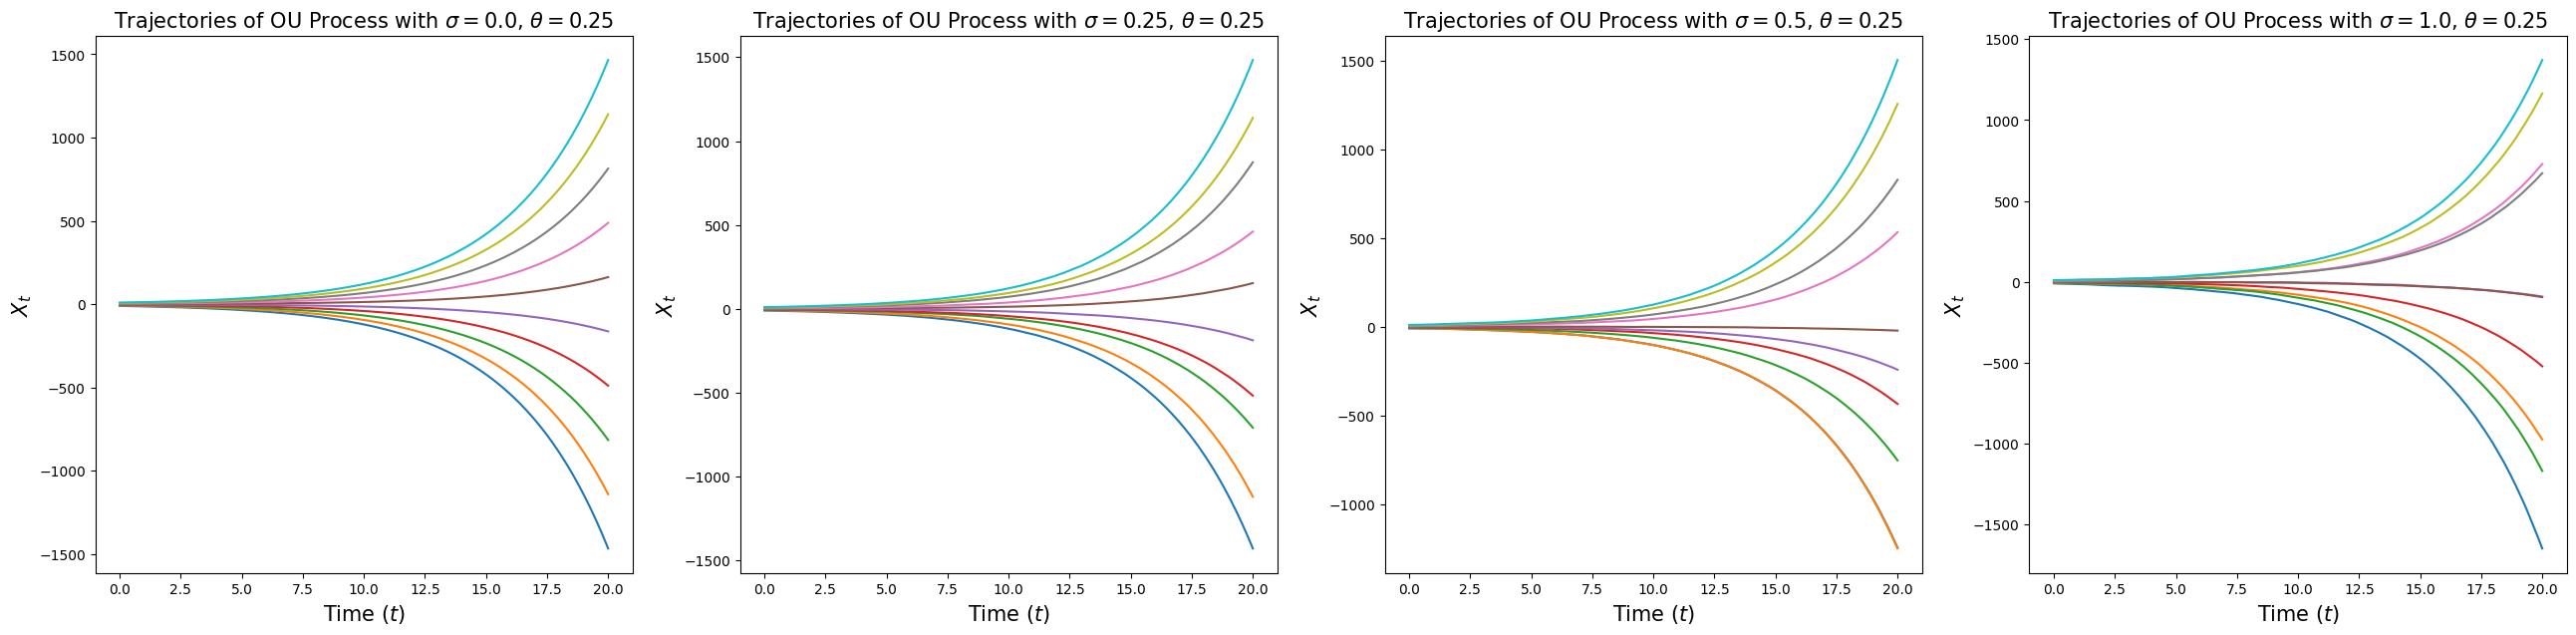

In [10]:
# Try comparing multiple choices side-by-side
thetas_and_sigmas = [
    (0.25, 0.0),
    (0.25, 0.25),
    (0.25, 0.5),
    (0.25, 1.0),
]
simulation_time = 20.0

num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 7))

for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
    ou_process = OUProcess(theta, sigma)
    simulator = EulerMaruyamaSimulator(sde=ou_process)
    x0 = torch.linspace(-10.0,10.0,10).view(-1,1).to(device) # Initial values - let's start at zero
    ts = torch.linspace(0.0,simulation_time,1000).to(device) # simulation timesteps

    ax = axes[idx]
    ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
    ax.set_xlabel(r'Time ($t$)', fontsize=15)
    ax.set_ylabel(r'$X_t$', fontsize=15)
    plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

**Your job**: What do you notice about the convergence of the solutions? Are they converging to a particular point? Or to a distribution? Your answer should be two *qualitative* sentences of the form: "When ($\theta$ or $\sigma$) goes (up or down), we see...".

**Hint**: Pay close attention to the ratio $D \triangleq \frac{\sigma^2}{2\theta}$ (see the next few cells below!).

**Your answer**: as $\sigma$ goes up, we see the solutions have larger variance at the end state.

In [11]:
def plot_scaled_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, time_scale: float, label: str, ax: Optional[Axes] = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - time_scale: scalar by which to scale time
            - label: self-explanatory
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
            ax.plot(ts.cpu() * time_scale, trajectory.cpu(), label=label)

100%|██████████| 999/999 [00:00<00:00, 5758.68it/s]


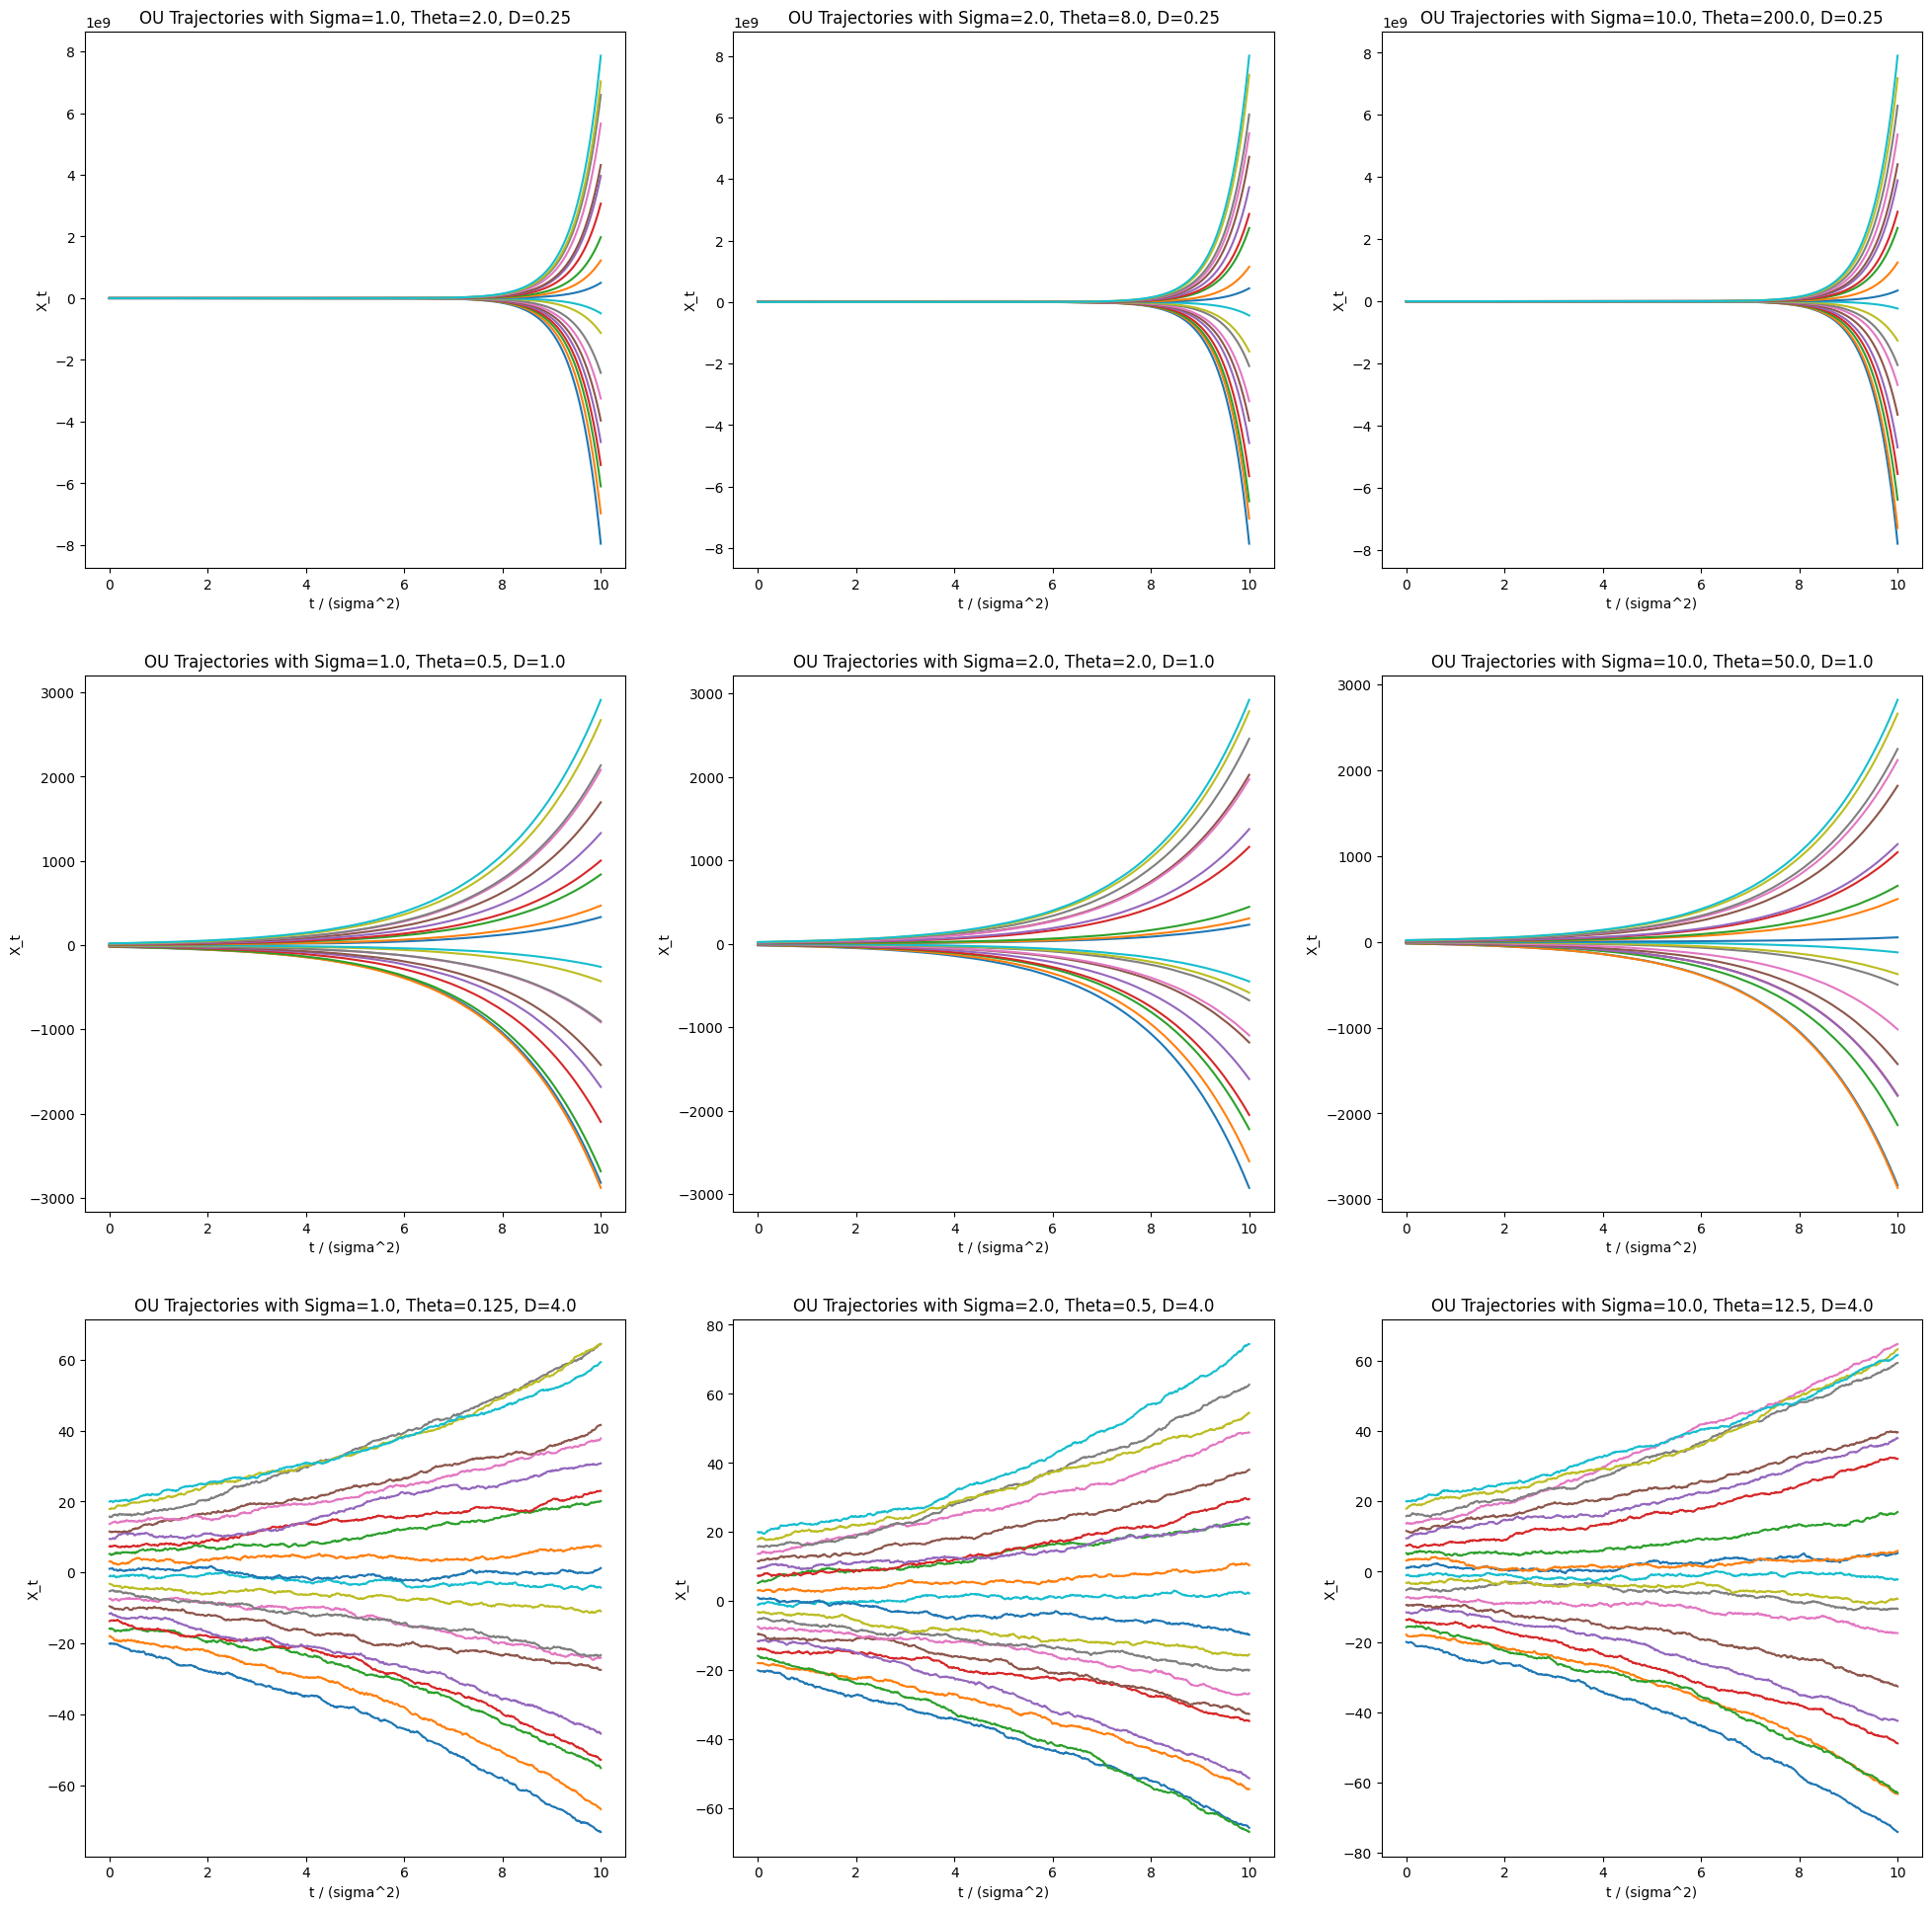

In [12]:
# Let's try rescaling with time
sigmas = [1.0, 2.0, 10.0]
ds = [0.25, 1.0, 4.0] # sigma**2 / 2t
simulation_time = 10.0

fig, axes = plt.subplots(len(ds), len(sigmas), figsize=(8 * len(sigmas), 8 * len(ds)))
axes = axes.reshape((len(ds), len(sigmas)))
for d_idx, d in enumerate(ds):
    for s_idx, sigma in enumerate(sigmas):
        theta = sigma**2 / 2 / d
        ou_process = OUProcess(theta, sigma)
        simulator = EulerMaruyamaSimulator(sde=ou_process)
        x0 = torch.linspace(-20.0,20.0,20).view(-1,1).to(device)
        time_scale = sigma**2
        ts = torch.linspace(0.0,simulation_time / time_scale,1000).to(device) # simulation timesteps
        ax = axes[d_idx, s_idx]
        plot_scaled_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, time_scale=time_scale, label=f'Sigma = {sigma}', ax=ax)
        ax.set_title(f'OU Trajectories with Sigma={sigma}, Theta={theta}, D={d}')
        ax.set_xlabel(f't / (sigma^2)')
        ax.set_ylabel('X_t')
plt.show()

**Your job**: What conclusion can we draw from the figure above? One qualitative sentence is fine. We'll revisit this in Section 3.2.

**Your answer**: we see that the stochastic trajactories are characterized by $D = \frac{\sigma^2}{2\theta}$ and as $D$ goes up, the trajectories diverge faster.

# Part 3: Transforming Distributions with SDEs
In the previous section, we observed how individual *points* are transformed by an SDE. Ultimately, we are interested in understanding how *distributions* are transformed by an SDE (or an ODE...). After all, our goal is to design ODEs and SDEs which transform a noisy distribution (such as the Gaussian $N(0, I_d)$), to the data distribution $p_{\text{data}}$ of interest. In this section, we will visualize how distributions are transformed by a very particular family of SDEs: *Langevin dynamics*.

First, let's define some distributions to play around with. In practice, there are two qualities one might hope a distribution to have:
1. The first quality is that one can measure the *density* of a distribution $p(x)$. This ensures that we can compute the gradient $\nabla \log p(x)$ of the log density. This quantity is known as the *score* of $p$, and paints a picture of the local geometry of the distribution. Using the score, we will construct and simulate the *Langevin dynamics*, a family of SDEs which "drive" samples toward the distribution $\pi$. In particular, the Langevin dynamics *preserve* the distribution $p(x)$. In Lecture 2, we will make this notion of driving more precise.
2. The second quality is that we can draw samples from the distribution $p(x)$.
For simple, toy distributions, such as Gaussians and simple mixture models, it is often true that both qualities are satisfied. For more complex choices of $p$, such as distributions over images, we can sample but cannot measure the density.

In [13]:
class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass

    def score(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the score dx log density(x)
        Args:
            - x: (batch_size, dim)
        Returns:
            - score: (batch_size, dim)
        """
        x = x.unsqueeze(1)  # (batch_size, 1, ...)
        score = vmap(jacrev(self.log_density))(x)  # (batch_size, 1, 1, 1, ...)
        return score.squeeze((1, 2, 3))  # (batch_size, ...)

class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """
        pass

In [14]:
# Several plotting utility functions
def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.hist2d(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def imshow_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

In [15]:
class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian. Is a Density and a Sampleable. Wrapper around torch.distributions.MultivariateNormal
    """
    def __init__(self, mean, cov):
        """
        mean: shape (2,)
        cov: shape (2,2)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0,
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


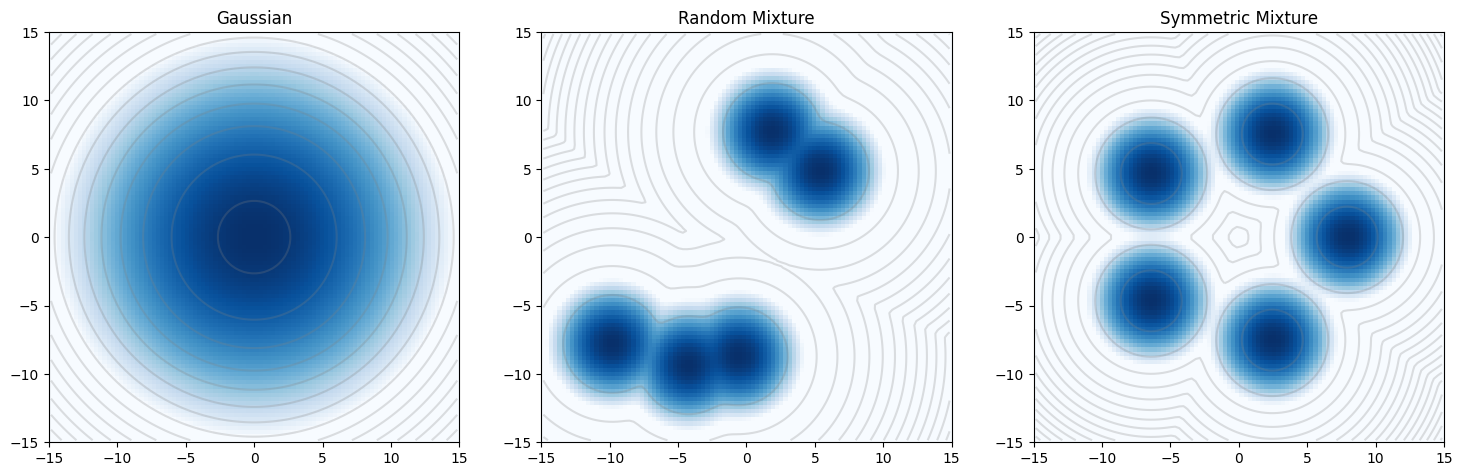

In [16]:
# Visualize densities
densities = {
    "Gaussian": Gaussian(mean=torch.zeros(2), cov=10 * torch.eye(2)).to(device),
    "Random Mixture": GaussianMixture.random_2D(nmodes=5, std=1.0, scale=20.0, seed=3.0).to(device),
    "Symmetric Mixture": GaussianMixture.symmetric_2D(nmodes=5, std=1.0, scale=8.0).to(device),
}

fig, axes = plt.subplots(1,3, figsize=(18, 6))
bins = 100
scale = 15
for idx, (name, density) in enumerate(densities.items()):
    ax = axes[idx]
    ax.set_title(name)
    imshow_density(density, bins, scale, ax, vmin=-15, cmap=plt.get_cmap('Blues'))
    contour_density(density, bins, scale, ax, colors='grey', linestyles='solid', alpha=0.25, levels=20)
plt.show()


### Question 3.1: Implementing Langevin Dynamics

In this section, we'll simulate the (overdamped) Langevin dynamics $$dX_t = \frac{1}{2} \sigma^2\nabla \log p(X_t) dt + \sigma dW_t.$$

**Your job**: Fill in the `drift_coefficient` and `diffusion_coefficient` methods of the class `LangevinSDE` below.

**Hint**: Use `Density.score` to access the score.

In [17]:
class LangevinSDE(SDE):
    def __init__(self, sigma: float, density: Density):
        self.sigma = sigma
        self.density = density

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return 0.5 * self.sigma**2 * self.density.score(xt)

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return self.sigma * torch.ones_like(xt)

Now, let's graph the results!

In [18]:
# First, let's define two utility functions...
def every_nth_index(num_timesteps: int, n: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory
    """
    if n == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, n),
            torch.tensor([num_timesteps - 1]),
        ]
    )

def graph_dynamics(
    num_samples: int,
    source_distribution: Sampleable,
    simulator: Simulator,
    density: Density,
    timesteps: torch.Tensor,
    plot_every: int,
    bins: int,
    scale: float
):
    """
    Plot the evolution of samples from source under the simulation scheme given by simulator (itself a discretization of an ODE or SDE).
    Args:
        - num_samples: the number of samples to simulate
        - source_distribution: distribution from which we draw initial samples at t=0
        - simulator: the discertized simulation scheme used to simulate the dynamics
        - density: the target density
        - timesteps: the timesteps used by the simulator
        - plot_every: number of timesteps between consecutive plots
        - bins: number of bins for imshow
        - scale: scale for imshow
    """
    # Simulate
    x0 = source_distribution.sample(num_samples)
    xts = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_plot = every_nth_index(len(timesteps), plot_every)
    plot_timesteps = timesteps[indices_to_plot]
    plot_xts = xts[:,indices_to_plot]

    # Graph
    fig, axes = plt.subplots(2, len(plot_timesteps), figsize=(8*len(plot_timesteps), 16))
    axes = axes.reshape((2,len(plot_timesteps)))
    for t_idx in range(len(plot_timesteps)):
        t = plot_timesteps[t_idx].item()
        xt = plot_xts[:,t_idx]
        # Scatter axes
        scatter_ax = axes[0, t_idx]
        imshow_density(density, bins, scale, scatter_ax, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        scatter_ax.scatter(xt[:,0].cpu(), xt[:,1].cpu(), marker='x', color='black', alpha=0.75, s=15)
        scatter_ax.set_title(f'Samples at t={t:.1f}', fontsize=15)
        scatter_ax.set_xticks([])
        scatter_ax.set_yticks([])

        # Kdeplot axes
        kdeplot_ax = axes[1, t_idx]
        imshow_density(density, bins, scale, kdeplot_ax, vmin=-15, alpha=0.5, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=xt[:,0].cpu(), y=xt[:,1].cpu(), alpha=0.5, ax=kdeplot_ax,color='grey')
        kdeplot_ax.set_title(f'Density of Samples at t={t:.1f}', fontsize=15)
        kdeplot_ax.set_xticks([])
        kdeplot_ax.set_yticks([])
        kdeplot_ax.set_xlabel("")
        kdeplot_ax.set_ylabel("")

    plt.show()

100%|██████████| 999/999 [00:05<00:00, 171.46it/s]


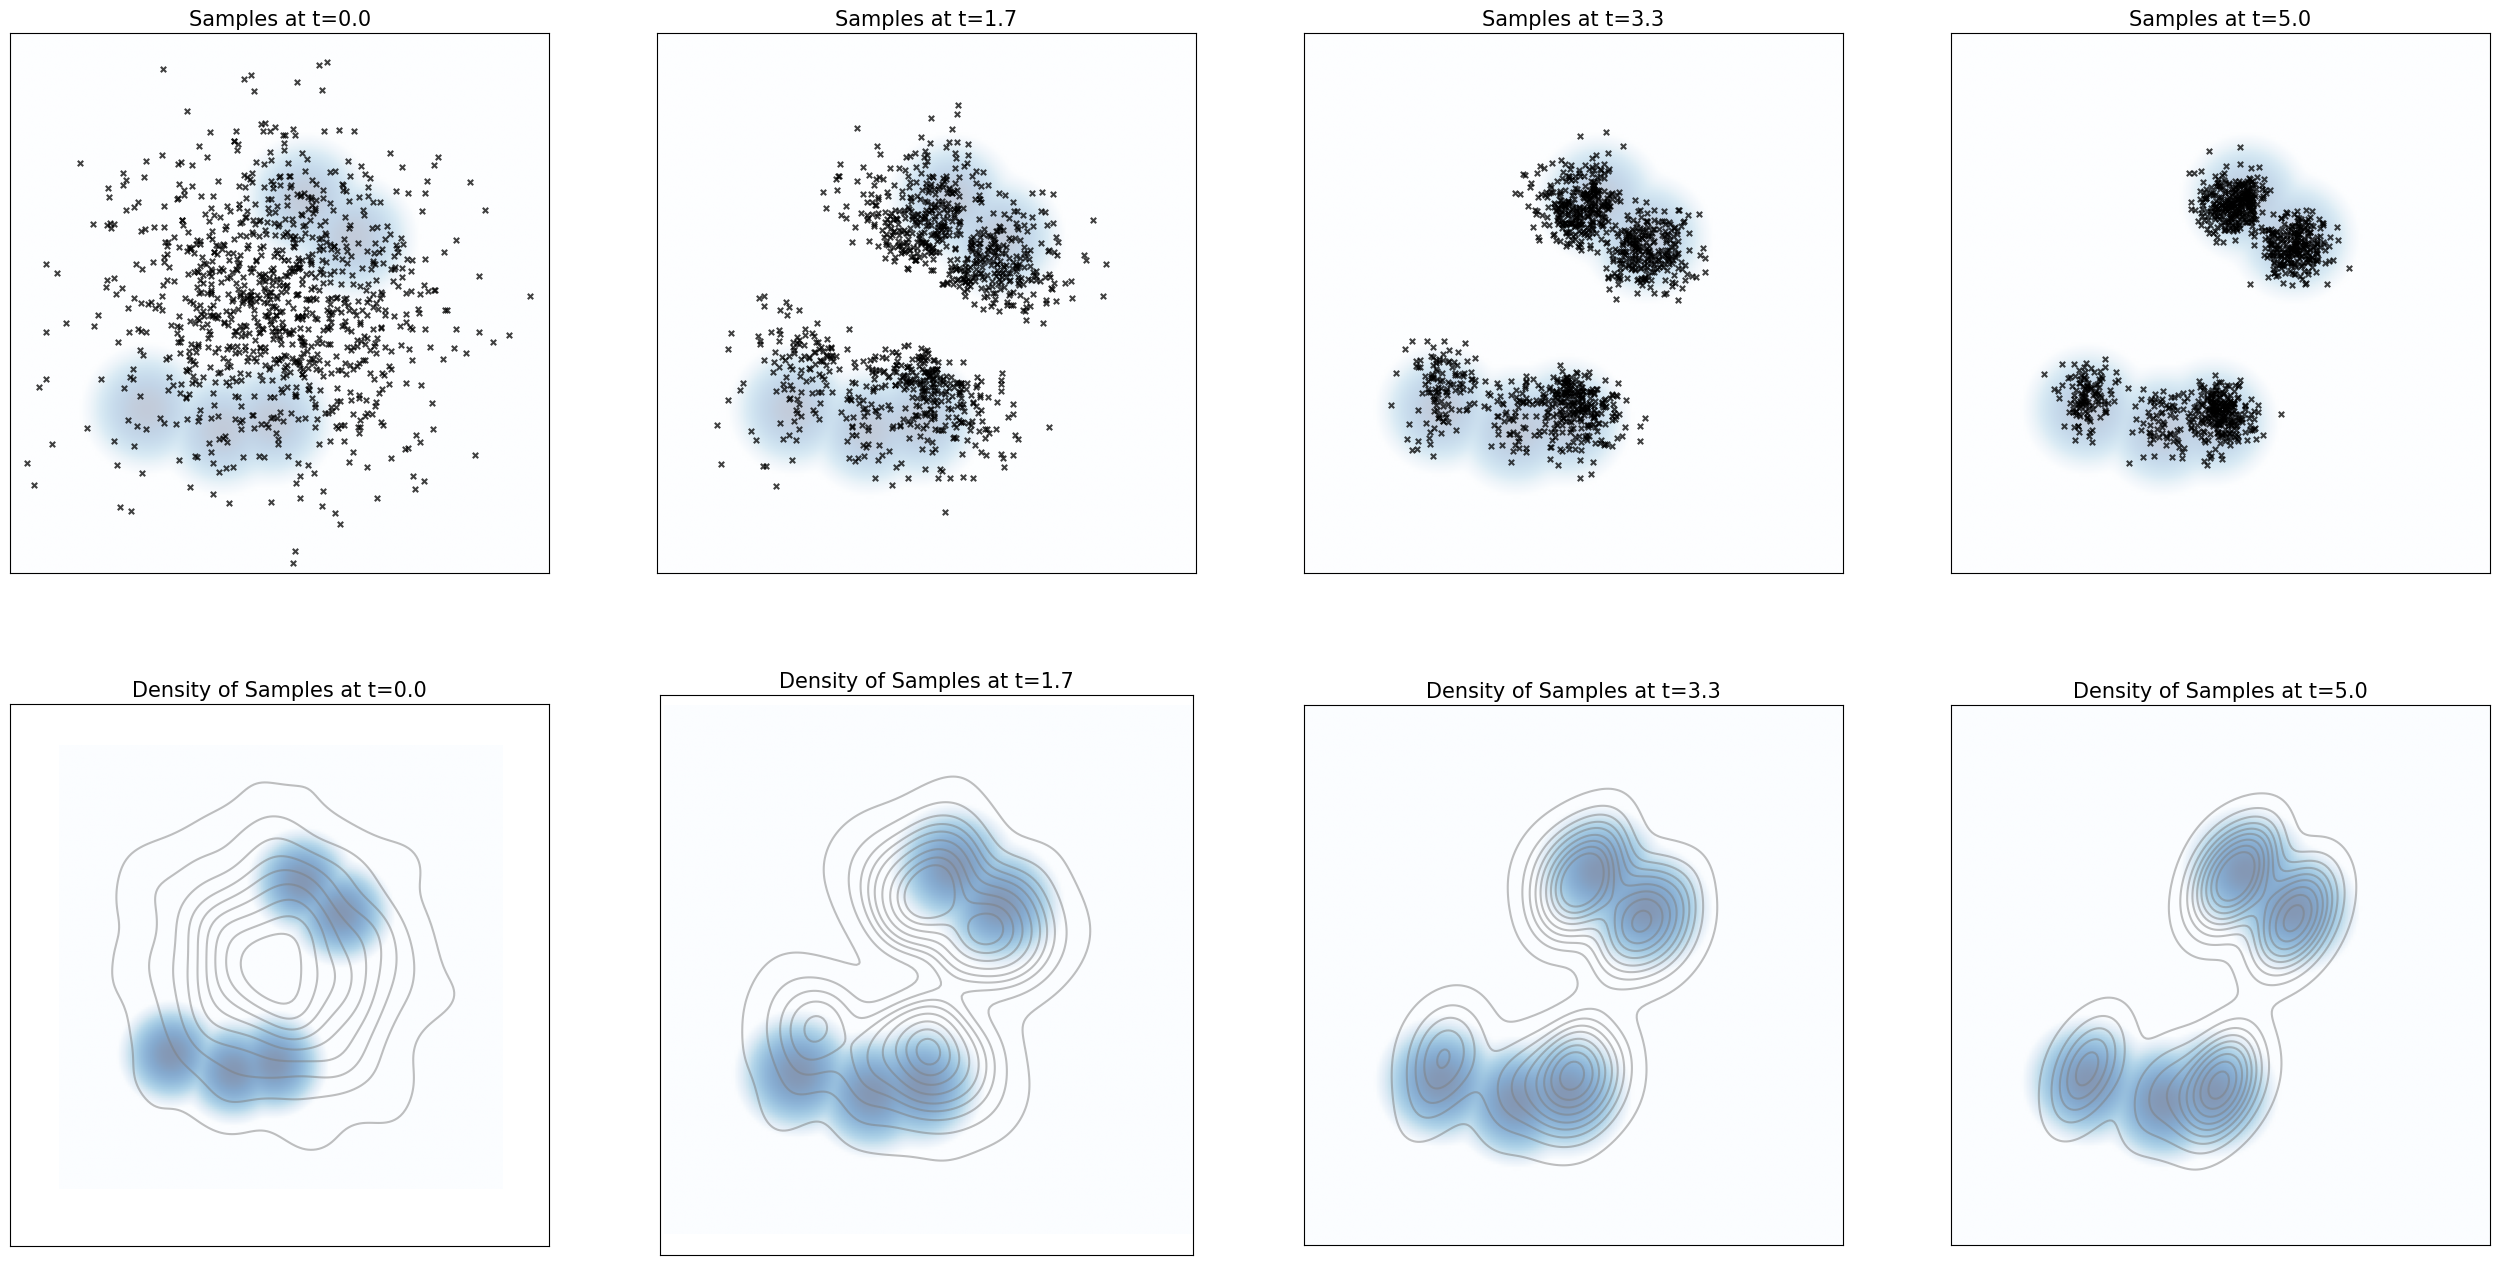

In [19]:
# Construct the simulator
target = GaussianMixture.random_2D(nmodes=5, std=0.75, scale=15.0, seed=3.0).to(device)
sde = LangevinSDE(sigma = 0.6, density = target)
simulator = EulerMaruyamaSimulator(sde)

# Graph the results!
graph_dynamics(
    num_samples = 1000,
    source_distribution = Gaussian(mean=torch.zeros(2), cov=20 * torch.eye(2)).to(device),
    simulator=simulator,
    density=target,
    timesteps=torch.linspace(0,5.0,1000).to(device),
    plot_every=334,
    bins=200,
    scale=15
)

**Your job**: Try varying the value of $\sigma$, the number and range of the simulation steps, the source distribution, and target density. What do you notice? Why?

**Your answer**:
- As $\sigma$ goes larger, the distribution converges faster to the target distribution
- Source distribution actually matters.


Note: To run the folowing two **optional** cells, you will need to download the `ffmpeg` library. You can do so using e.g., `conda install -c conda-forge ffmpeg` (or, ideally, `mamba`). Running `pip install ffmpeg` or similar will likely **not** work.

In [ ]:
from celluloid import Camera
from IPython.display import HTML

def animate_dynamics(
    num_samples: int,
    source_distribution: Sampleable,
    simulator: Simulator,
    density: Density,
    timesteps: torch.Tensor,
    animate_every: int,
    bins: int,
    scale: float,
    save_path: str = 'dynamics_animation.mp4'
):
    """
    Plot the evolution of samples from source under the simulation scheme given by simulator (itself a discretization of an ODE or SDE).
    Args:
        - num_samples: the number of samples to simulate
        - source_distribution: distribution from which we draw initial samples at t=0
        - simulator: the discertized simulation scheme used to simulate the dynamics
        - density: the target density
        - timesteps: the timesteps used by the simulator
        - animate_every: number of timesteps between consecutive frames in the resulting animation
    """
    # Simulate
    x0 = source_distribution.sample(num_samples)
    xts = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_animate = every_nth_index(len(timesteps), animate_every)
    animate_timesteps = timesteps[indices_to_animate]
    animate_xts = xts[:, indices_to_animate]

    # Graph
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    camera = Camera(fig)
    for t_idx in range(len(animate_timesteps)):
        t = animate_timesteps[t_idx].item()
        xt = animate_xts[:,t_idx]
        # Scatter axes
        scatter_ax = axes[0]
        imshow_density(density, bins, scale, scatter_ax, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        scatter_ax.scatter(xt[:,0].cpu(), xt[:,1].cpu(), marker='x', color='black', alpha=0.75, s=15)
        scatter_ax.set_title(f'Samples')

        # Kdeplot axes
        kdeplot_ax = axes[1]
        imshow_density(density, bins, scale, kdeplot_ax, vmin=-15, alpha=0.5, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=xt[:,0].cpu(), y=xt[:,1].cpu(), alpha=0.5, ax=kdeplot_ax,color='grey')
        kdeplot_ax.set_title(f'Density of Samples', fontsize=15)
        kdeplot_ax.set_xticks([])
        kdeplot_ax.set_yticks([])
        kdeplot_ax.set_xlabel("")
        kdeplot_ax.set_ylabel("")
        camera.snap()

    animation = camera.animate()
    animation.save(save_path)
    plt.close()
    return HTML(animation.to_html5_video())

In [ ]:
# OPTIONAL CELL
# Construct the simulator
target = GaussianMixture.random_2D(nmodes=5, std=0.75, scale=15.0, seed=3.0).to(device)
sde = LangevinSDE(sigma = 0.6, density = target)
simulator = EulerMaruyamaSimulator(sde)

# Graph the results!
animate_dynamics(
    num_samples = 1000,
    source_distribution = Gaussian(mean=torch.zeros(2), cov=20 * torch.eye(2)).to(device),
    simulator=simulator,
    density=target,
    timesteps=torch.linspace(0,5.0,1000).to(device),
    bins=200,
    scale=15,
    animate_every=100
)

### Question 3.2: Ornstein-Uhlenbeck as Langevin Dynamics
In this section, we'll finish off with a brief mathematical exercise connecting Langevin dynamics and Ornstein-Uhlenbeck processes. Recall that for (suitably nice) distribution $p$, the *Langevin dynamics* are given by
$$dX_t = \frac{1}{2} \sigma^2\nabla \log p(X_t) dt + \sigma\, dW_t, \quad \quad X_0 = x_0,$$
while for given $\theta, \sigma$, the Ornstein-Uhlenbeck process is given by
$$dX_t = -\theta X_t\, dt + \sigma\, dW_t, \quad \quad X_0 = x_0.$$

**Your job**: Show that when $p(x) = N(0, \frac{\sigma^2}{2\theta})$, the score is given by $$\nabla \log p(x) = -\frac{2\theta}{\sigma^2}x.$$

**Hint**: The probability density of the Gaussian $p(x) = N(0, \frac{\sigma^2}{2\theta})$ is given by $$p(x)  = \frac{\sqrt{\theta}}{\sigma\sqrt{\pi}} \exp\left(-\frac{x^2\theta}{\sigma^2}\right).$$

**Your answer**:

**Your job**: Conclude that when $p(x) = N(0, \frac{\sigma^2}{2\theta})$, the Langevin dynamics
$$dX_t = \frac{1}{2} \sigma^2\nabla \log p(X_t) dt + \sigma dW_t,$$
is equivalent to the Ornstein-Uhlenbeck process
$$ dX_t = -\theta X_t\, dt + \sigma\, dW_t, \quad \quad X_0 = 0.$$

**Your answer**:
Take the derivatives of $\frac{1}{2} \sigma^2\nabla \log p(X_t)$ with respect to $x$.